El dataset "Amazon Stock Data" contiene información histórica sobre el precio de las acciones de Amazon (AMZN). Incluye columnas como la fecha, el precio de apertura, el precio de cierre, el precio máximo y mínimo del día, el volumen de transacciones y el precio de cierre ajustado. Este tipo de datos es útil para analizar tendencias del mercado, realizar análisis técnico y desarrollar modelos de predicción financiera.

In [4]:
#Importacion de librerias y configuraciones
import os
import random
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tqdm.notebook import tqdm

# Ignorar warnings para limpieza
warnings.filterwarnings("ignore")

# Fijar semilla para reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Selección automática de dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Crear carpeta para resultados
RESULTS_DIR = Path("results_rnn")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)


Usando dispositivo: cuda


In [7]:
#Carga y limpieza

CSV_PATH = r"C:\Users\jhean\Documents\Universidad\IA2\Lab03\Amazon_stock_data.csv"

#Forzamos parseo de fecha y orden temporal
df = pd.read_csv(
    CSV_PATH,
    parse_dates=["Date"],
    dtype={"Open": "float64", "High": "float64", "Low": "float64", "Close": "float64", "Volume": "int64"}
)

#Normalizamos nombres (por si vienen con espacios)
df.columns = [c.strip() for c in df.columns]

#Columnas esperadas
expected_cols = {"Date", "Open", "High", "Low", "Close", "Volume"}
missing_cols = expected_cols - set(df.columns)
if missing_cols:
    raise ValueError(f"Faltan columnas en el CSV: {missing_cols}. Columnas encontradas: {list(df.columns)}")

#Orden y duplicados
df = df.sort_values("Date").reset_index(drop=True)

dup_count = df.duplicated(subset=["Date"]).sum()
if dup_count > 0:
    print(f"Se encontraron {dup_count} filas duplicadas por fecha. Se eliminarán conservando la última.")
    df = df.drop_duplicates(subset=["Date"], keep="last").reset_index(drop=True)

#Valores faltantes (encaso de existir)
na_before = df.isna().sum()
if na_before.any():
    print("Valores faltantes antes de imputación:\n", na_before.to_string())
    df[["Open","High","Low","Close","Volume"]] = df[["Open","High","Low","Close","Volume"]].ffill().bfill()

na_after = df.isna().sum()
if na_after.any():
    print("Persisten NaN después de imputación:\n", na_after.to_string())

nonpos_mask = (df[["Open","High","Low","Close"]] <= 0).any(axis=1)
nonpos_count = int(nonpos_mask.sum())
if nonpos_count > 0:
    print(f"Hay {nonpos_count} filas con precios no positivos. Se imputarán por forward-fill/back-fill.")
    for col in ["Open","High","Low","Close"]:
        m = df[col] <= 0
        if m.any():
            df.loc[m, col] = np.nan
            df[col] = df[col].ffill().bfill()
bad_hilo = (df["High"] < df["Low"]).sum()
if bad_hilo > 0:
    print(f"{bad_hilo} filas con High < Low. Se corrigen intercambiando.")
    hi = df["High"].copy()
    lo = df["Low"].copy()
    swap_idx = hi < lo
    df.loc[swap_idx, "High"] = lo[swap_idx]
    df.loc[swap_idx, "Low"]  = hi[swap_idx]

df["Return"] = np.log(df["Close"] / df["Close"].shift(1))
df["MA7"]  = df["Close"].rolling(7, min_periods=1).mean()
df["MA21"] = df["Close"].rolling(21, min_periods=1).mean()
if df["Return"].isna().any():
    print("La primera fila de Return es NaN. No se elimina ninguna")

#Resumen
print("====== RESUMEN DEL DATASET ======")
print(f"Filas: {len(df):,} | Columnas: {len(df.columns)}")
print(f"Rango de fechas: {df['Date'].min().date()} → {df['Date'].max().date()}")
print("\nValores faltantes por columna:")
print(df.isna().sum().to_string())

#Descriptivos
print("\nEstadísticos (Close, Volume, Return):")
print(df[["Close", "Volume", "Return"]].describe(percentiles=[0.01,0.05,0.5,0.95,0.99]).to_string())

#Guardar
CLEAN_PATH = RESULTS_DIR / "amazon_clean.csv"
df.to_csv(CLEAN_PATH, index=False)
print(f"Dataset limpio guardado en: {CLEAN_PATH.resolve()}")


La primera fila de Return es NaN. No se elimina ninguna
====== RESUMEN DEL DATASET ======
Filas: 7,107 | Columnas: 9
Rango de fechas: 1997-05-15 → 2025-08-14

Valores faltantes por columna:
Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
Return    1
MA7       0
MA21      0

Estadísticos (Close, Volume, Return):
             Close        Volume       Return
count  7107.000000  7.107000e+03  7106.000000
mean     43.471275  1.345628e+08     0.001093
std      61.465180  1.369077e+08     0.034571
min       0.069792  9.744000e+06    -0.284568
1%        0.119854  2.665368e+07    -0.096663
5%        0.510450  3.789096e+07    -0.048704
50%       9.276500  9.922000e+07     0.000423
95%     176.584746  3.456458e+08     0.049842
99%     220.548203  7.378681e+08     0.115202
max     242.059998  2.086584e+09     0.296181
Dataset limpio guardado en: C:\Users\jhean\Documents\Universidad\IA2\Lab03\results_rnn\amazon_clean.csv


In [8]:
# =======================
# 5-6. SPLIT TEMPORAL + ESCALADO (fit en train, transform en val/test)
# =======================

from joblib import dump

# --- Cargar el limpio si no existe df en memoria ---
try:
    _ = df.shape
except NameError:
    CLEAN_PATH = RESULTS_DIR / "amazon_clean.csv"
    df = pd.read_csv(CLEAN_PATH, parse_dates=["Date"])
    df.columns = [c.strip() for c in df.columns]

# --- Configuración ---
TARGET_COL = "Close"       # cambia a "Return" si prefieres modelar rendimientos
USE_LOG_VOLUME = True      # True: usa log1p(Volume) como feature

# --- Features base ---
_df = df.copy()

# Manejo de Volume (opcional log)
if USE_LOG_VOLUME:
    _df["Volume_log"] = np.log1p(_df["Volume"])
    feature_cols = ["Open", "High", "Low", "Close", "Volume_log", "MA7", "MA21", "Return"]
else:
    feature_cols = ["Open", "High", "Low", "Close", "Volume", "MA7", "MA21", "Return"]

# El primer Return es NaN por construcción; evitamos problemas en escalado
_df = _df.dropna(subset=feature_cols + [TARGET_COL]).reset_index(drop=True)

# Matrices X/y
X_all = _df[feature_cols].values.astype(np.float32)
y_all = _df[[TARGET_COL]].values.astype(np.float32)

dates_all = _df["Date"].values  # por si querés trazar luego

# --- Split temporal 70/15/15 ---
n = len(_df)
n_train = int(n * 0.70)
n_val   = int(n * 0.15)
n_test  = n - n_train - n_val

idx_train_end = n_train
idx_val_end   = n_train + n_val

X_train, y_train = X_all[:idx_train_end], y_all[:idx_train_end]
X_val,   y_val   = X_all[idx_train_end:idx_val_end], y_all[idx_train_end:idx_val_end]
X_test,  y_test  = X_all[idx_val_end:], y_all[idx_val_end:]

dates_train = dates_all[:idx_train_end]
dates_val   = dates_all[idx_train_end:idx_val_end]
dates_test  = dates_all[idx_val_end:]

print(f"Split -> train: {len(X_train)}, val: {len(X_val)}, test: {len(X_test)}")

# --- Escalado (fit SOLO en train) ---
scaler_X = MinMaxScaler()   # o StandardScaler()
scaler_y = MinMaxScaler()   # escalar target por separado

scaler_X.fit(X_train)
scaler_y.fit(y_train)

X_train_s = scaler_X.transform(X_train)
X_val_s   = scaler_X.transform(X_val)
X_test_s  = scaler_X.transform(X_test)

y_train_s = scaler_y.transform(y_train)
y_val_s   = scaler_y.transform(y_val)
y_test_s  = scaler_y.transform(y_test)

# --- Guardar scalers para reproducibilidad ---
dump(scaler_X, RESULTS_DIR / "scaler_X.pkl")
dump(scaler_y, RESULTS_DIR / "scaler_y.pkl")

# --- Reporte rápido ---
print("Shapes (escaladas):")
print("X_train_s:", X_train_s.shape, "| y_train_s:", y_train_s.shape)
print("X_val_s:  ", X_val_s.shape,   "| y_val_s:  ", y_val_s.shape)
print("X_test_s: ", X_test_s.shape,  "| y_test_s: ", y_test_s.shape)

# Para el siguiente bloque (secuencias) dejamos todo en memoria:
# X_train_s, y_train_s, X_val_s, y_val_s, X_test_s, y_test_s, feature_cols, TARGET_COL


Split -> train: 4974, val: 1065, test: 1067
Shapes (escaladas):
X_train_s: (4974, 8) | y_train_s: (4974, 1)
X_val_s:   (1065, 8) | y_val_s:   (1065, 1)
X_test_s:  (1067, 8) | y_test_s:  (1067, 1)


In [9]:
# =======================
# 7-8. SECUENCIAS (VENTANAS) + DATASETS/DATALOADERS
# =======================

# Hiperparámetros de ventana y batch
LOOKBACK = 60   # días hacia atrás
HORIZON  = 1    # predicción directa de t+1 (puedes poner >1 para multi-step)
BATCH_SIZE = 64

def make_sequences(X, y, lookback=60, horizon=1):
    """
    Convierte matrices [N, n_features] y [N, 1] en tensores de secuencias:
      X_seq: [M, lookback, n_features]
      y_seq: [M, horizon] (si horizon=1 -> [M, 1])
    Importante: NO hay fuga temporal; solo usa pasado para predecir futuro inmediato.
    """
    X_list, y_list = [], []
    N = len(X)
    last_start = N - (lookback + horizon) + 1
    if last_start <= 0:
        raise ValueError(f"No hay suficientes muestras para lookback={lookback} y horizon={horizon} con N={N}")
    for start in range(last_start):
        end = start + lookback
        y_end = end + horizon
        X_list.append(X[start:end])
        y_list.append(y[end:y_end].reshape(-1))  # [horizon]
    X_seq = np.stack(X_list).astype(np.float32)
    y_seq = np.stack(y_list).astype(np.float32)
    return X_seq, y_seq

# Generar secuencias por split (usamos los arrays *_s del bloque anterior)
Xtr_seq, ytr_seq = make_sequences(X_train_s, y_train_s, LOOKBACK, HORIZON)
Xva_seq, yva_seq = make_sequences(X_val_s,   y_val_s,   LOOKBACK, HORIZON)
Xte_seq, yte_seq = make_sequences(X_test_s,  y_test_s,  LOOKBACK, HORIZON)

print("Shapes de secuencias:")
print("Train:", Xtr_seq.shape, ytr_seq.shape)
print("Val:  ", Xva_seq.shape, yva_seq.shape)
print("Test: ", Xte_seq.shape, yte_seq.shape)

# Dataset PyTorch
class SeqDataset(Dataset):
    def __init__(self, X_seq, y_seq):
        self.X = torch.from_numpy(X_seq)              # [M, lookback, n_features]
        self.y = torch.from_numpy(y_seq)              # [M, horizon]
        if self.y.ndim == 1:
            self.y = self.y.unsqueeze(1)              # [M, 1] si horizon=1

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Instancias de Dataset
ds_train = SeqDataset(Xtr_seq, ytr_seq)
ds_val   = SeqDataset(Xva_seq, yva_seq)
ds_test  = SeqDataset(Xte_seq, yte_seq)

# DataLoaders
dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True,  drop_last=True)
dl_val   = DataLoader(ds_val,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
dl_test  = DataLoader(ds_test,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# Chequeo rápido de un batch
xb, yb = next(iter(dl_train))
print(f"Batch X: {xb.shape} | Batch y: {yb.shape}")  # ej: [64, 60, n_features] | [64, 1] si HORIZON=1

# Variables clave para el siguiente bloque (modelo):
# - n_features:
n_features = Xtr_seq.shape[-1]
print("n_features =", n_features, "| lookback =", LOOKBACK, "| horizon =", HORIZON)


Shapes de secuencias:
Train: (4914, 60, 8) (4914, 1)
Val:   (1005, 60, 8) (1005, 1)
Test:  (1007, 60, 8) (1007, 1)
Batch X: torch.Size([64, 60, 8]) | Batch y: torch.Size([64, 1])
n_features = 8 | lookback = 60 | horizon = 1


In [14]:
# =======================
# 9. MODELO: SimpleRNN (solo)
# =======================

import torch.nn as nn

class SimpleRNNRegressor(nn.Module):
    """
    Regressor con SimpleRNN (tanh).
    Entrada:  [B, T, n_features]
    Salida:   [B, HORIZON]
    """
    def __init__(
        self,
        input_size: int,
        hidden_size: int = 64,
        num_layers: int = 1,
        dropout: float = 0.0,   # se aplica solo si num_layers > 1
        horizon: int = 1,
        bidirectional: bool = False,
        batch_first: bool = True,
    ):
        super().__init__()
        self.horizon = horizon

        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            nonlinearity="tanh",
            dropout=(dropout if num_layers > 1 else 0.0),
            bidirectional=bidirectional,
            batch_first=batch_first,
        )
        out_feats = hidden_size * (2 if bidirectional else 1)
        self.fc = nn.Linear(out_feats, horizon)

    def forward(self, x):
        out, _ = self.rnn(x)      # [B, T, hidden*dirs]
        last = out[:, -1, :]      # último paso temporal
        y = self.fc(last)         # [B, horizon]
        return y

# ---- Instancia recomendada ----
HIDDEN_SIZE = 64
NUM_LAYERS  = 1      # SimpleRNN estable con 1 capa; puedes subir a 2 y activar dropout
DROPOUT     = 0.0
BIDIR       = False

rnn_model = SimpleRNNRegressor(
    input_size=n_features,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
    horizon=HORIZON,
    bidirectional=BIDIR
).to(device)

print("Parámetros del rnn_model:", sum(p.numel() for p in rnn_model.parameters()))


Parámetros del rnn_model: 4801


Epoch 001 | train_loss=0.001816 | val_loss=0.725875 | lr=1.00e-03  <- best
Epoch 002 | train_loss=0.000074 | val_loss=0.604426 | lr=1.00e-03  <- best
Epoch 003 | train_loss=0.000063 | val_loss=0.545477 | lr=1.00e-03  <- best
Epoch 004 | train_loss=0.000067 | val_loss=0.495513 | lr=1.00e-03  <- best
Epoch 005 | train_loss=0.000064 | val_loss=0.450782 | lr=1.00e-03  <- best
Epoch 006 | train_loss=0.000056 | val_loss=0.410643 | lr=1.00e-03  <- best
Epoch 007 | train_loss=0.000052 | val_loss=0.394500 | lr=1.00e-03  <- best
Epoch 008 | train_loss=0.000059 | val_loss=0.368299 | lr=1.00e-03  <- best
Epoch 009 | train_loss=0.000055 | val_loss=0.346938 | lr=1.00e-03  <- best
Epoch 010 | train_loss=0.000057 | val_loss=0.331918 | lr=1.00e-03  <- best
Epoch 011 | train_loss=0.000054 | val_loss=0.317823 | lr=1.00e-03  <- best
Epoch 012 | train_loss=0.000051 | val_loss=0.309124 | lr=1.00e-03  <- best
Epoch 013 | train_loss=0.000046 | val_loss=0.293821 | lr=1.00e-03  <- best
Epoch 014 | train_loss=0.

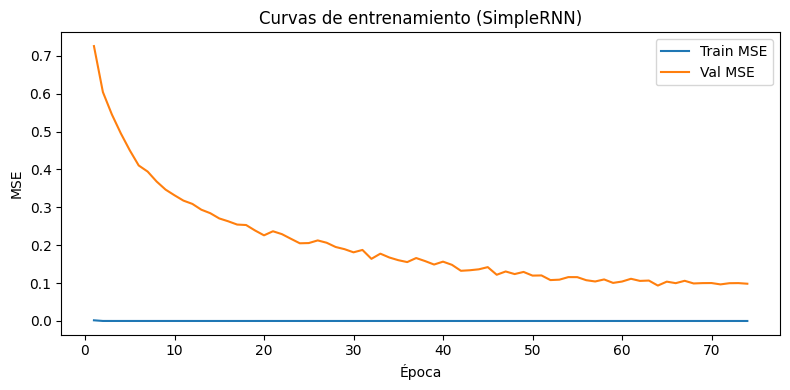

In [16]:
# =======================
# 10-11. ENTRENAMIENTO: pérdida, optimizador, scheduler, early stopping (solo rnn_model)
# =======================

import math
from copy import deepcopy
from time import time

# --- Modelo a entrenar: SimpleRNN ---
model = rnn_model.to(device)

# --- Configuración de entrenamiento ---
EPOCHS       = 150
LR           = 1e-3
PATIENCE     = 10
WEIGHT_DECAY = 0.0
MAX_NORM     = 1.0          # grad clipping (0 o None para desactivar)
USE_AMP      = True         # mixed precision en GPU (si hay CUDA)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=3, factor=0.5)

scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP and (device.type == "cuda"))

# --- EarlyStopping sencillo ---
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best = math.inf
        self.counter = 0
        self.best_state = None

    def step(self, value, model):
        improved = (self.best - value) > self.min_delta
        if improved:
            self.best = value
            self.counter = 0
            self.best_state = deepcopy(model.state_dict())
            return True
        else:
            self.counter += 1
            return False

    @property
    def should_stop(self):
        return self.counter >= self.patience

early = EarlyStopping(patience=PATIENCE, min_delta=0.0)

# --- Funciones de train/val ---
def run_epoch(dloader, model, train=True):
    model.train(mode=train)
    total_loss, n_samples = 0.0, 0

    for xb, yb in dloader:
        xb = xb.to(device)   # [B, T, n_features]
        yb = yb.to(device)   # [B, horizon]

        if train:
            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=USE_AMP and (device.type == "cuda")):
                pred = model(xb)              # [B, horizon]
                loss = criterion(pred, yb)    # MSE (en escala normalizada)
            scaler.scale(loss).backward()
            if MAX_NORM and MAX_NORM > 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_NORM)
            scaler.step(optimizer)
            scaler.update()
        else:
            with torch.no_grad():
                pred = model(xb)
                loss = criterion(pred, yb)

        bs = xb.size(0)
        total_loss += loss.item() * bs
        n_samples  += bs

    return total_loss / max(n_samples, 1)

# --- Loop de entrenamiento ---
history = {"epoch": [], "train_loss": [], "val_loss": [], "lr": []}
best_path = RESULTS_DIR / "best_rnn_model.pt"

t0 = time()
for epoch in range(1, EPOCHS + 1):
    tr_loss = run_epoch(dl_train, model, train=True)
    va_loss = run_epoch(dl_val,   model, train=False)

    # Scheduler on val
    scheduler.step(va_loss)

    # Early stopping y guardado del mejor
    is_best = early.step(va_loss, model)
    if is_best:
        torch.save(early.best_state, best_path)

    # Log
    current_lr = optimizer.param_groups[0]["lr"]
    history["epoch"].append(epoch)
    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["lr"].append(current_lr)

    print(f"Epoch {epoch:03d} | train_loss={tr_loss:.6f} | val_loss={va_loss:.6f} | lr={current_lr:.2e}" +
          ("  <- best" if is_best else ""))

    if early.should_stop:
        print(f"⏹️  Early stopping en epoch {epoch}. Mejor val_loss: {early.best:.6f}")
        break

t1 = time()
print(f"⏱️  Tiempo total: {t1 - t0:.1f}s")
print(f"💾 Mejor modelo guardado en: {best_path.resolve()} (val_loss={early.best:.6f})")

# --- Gráfico de la curva de entrenamiento ---
plt.figure(figsize=(8,4))
plt.plot(history["epoch"], history["train_loss"], label="Train MSE")
plt.plot(history["epoch"], history["val_loss"], label="Val MSE")
plt.title("Curvas de entrenamiento (SimpleRNN)")
plt.xlabel("Época"); plt.ylabel("MSE"); plt.legend(); plt.tight_layout()
plt.show()


MAE  = 28.5174
RMSE = 34.8429
MAPE = 16.08%


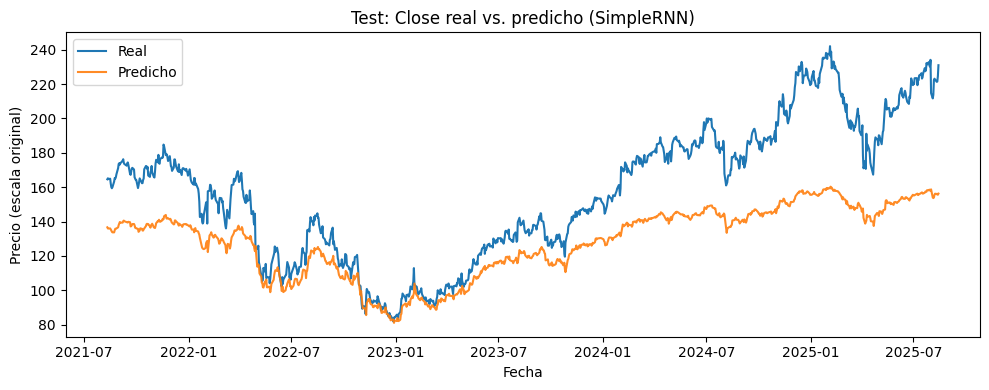

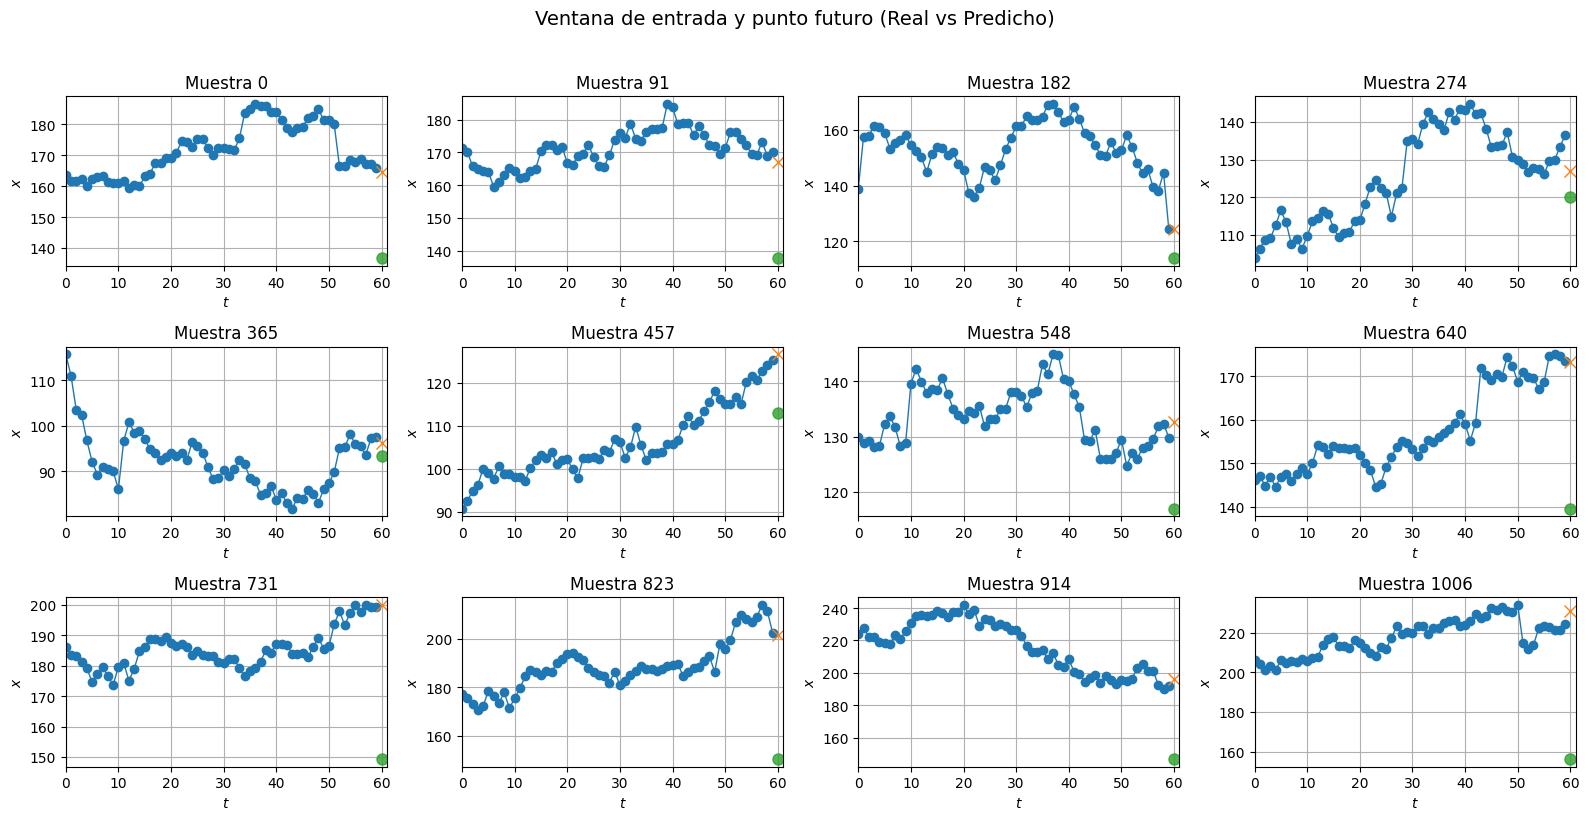

In [19]:
# =======================
# 12. EVALUACIÓN EN TEST + GRÁFICAS (incluye rejilla tipo ejemplo)
# =======================

from math import sqrt
import numpy as np
import torch

# --- Cargar mejor modelo ---
best_path = RESULTS_DIR / "best_rnn_model.pt"
state = torch.load(best_path, map_location=device)
rnn_model.load_state_dict(state)
rnn_model.eval()

# --- Predicciones en test (en escala normalizada) ---
y_true_s = []
y_pred_s = []
with torch.no_grad():
    for xb, yb in dl_test:
        xb = xb.to(device)
        pred = rnn_model(xb)          # [B, horizon]
        y_true_s.append(yb.numpy())   # CPU numpy
        y_pred_s.append(pred.cpu().numpy())

y_true_s = np.concatenate(y_true_s, axis=0)  # [M, horizon]
y_pred_s = np.concatenate(y_pred_s, axis=0)  # [M, horizon]

# --- Desescalar a valores originales ---
# y_*_s tienen forma [M, HORIZON]; scaler_y espera 2D => ya está OK
y_true = scaler_y.inverse_transform(y_true_s)  # [M, H]
y_pred = scaler_y.inverse_transform(y_pred_s)  # [M, H]

# Para HORIZON=1, aplanamos por comodidad
if y_true.shape[1] == 1:
    y_true = y_true.ravel()
    y_pred = y_pred.ravel()

# --- Métricas ---
def mape(y, yhat, eps=1e-8):
    return np.mean(np.abs((y - yhat) / (np.abs(y) + eps))) * 100.0

MAE  = np.mean(np.abs(y_true - y_pred))
RMSE = sqrt(np.mean((y_true - y_pred)**2))
MAPE = mape(y_true, y_pred)

print(f"MAE  = {MAE:.4f}")
print(f"RMSE = {RMSE:.4f}")
print(f"MAPE = {MAPE:.2f}%")

# --- Fechas alineadas para las etiquetas del test ---
# y_test_s proviene de X_test_s/y_test_s tras make_sequences.
# La primera predicción corresponde a la fecha: dates_test[LOOKBACK]
dates_test_seq = pd.to_datetime(dates_test)
dates_pred = dates_test_seq[LOOKBACK : LOOKBACK + len(y_true)]

# --- Gráfico 1: serie completa test (real vs predicho) ---
plt.figure(figsize=(10,4))
plt.plot(dates_pred, y_true, label="Real")
plt.plot(dates_pred, y_pred, label="Predicho", alpha=0.9)
plt.title("Test: Close real vs. predicho (SimpleRNN)")
plt.xlabel("Fecha"); plt.ylabel("Precio (escala original)")
plt.legend(); plt.tight_layout()
plt.show()

# --- Gráfico 2: rejilla tipo ejemplo (ventana + punto futuro) ---
# Necesitamos reconstruir la secuencia de 'Close' en escala original desde Xte_seq
# Identificar el índice de 'Close' en feature_cols
try:
    close_idx = feature_cols.index("Close")
except ValueError:
    raise ValueError("No se encontró 'Close' en feature_cols. Verifica el bloque de features.")

def inv_transform_X_seq(X_seq_scaled, scaler_X):
    """
    Desescala una secuencia X_seq_scaled de forma [T, n_features] a escala original.
    """
    T, F = X_seq_scaled.shape
    x_flat = X_seq_scaled.reshape(-1, F)
    x_inv  = scaler_X.inverse_transform(x_flat)
    return x_inv.reshape(T, F)

# Tomamos algunas muestras del conjunto de test ya preparado (Xte_seq / yte_seq)
N_PLOTS = 12                 # cantidad de paneles
ROWS, COLS = 3, 4
idxs = np.linspace(0, len(Xte_seq)-1, N_PLOTS, dtype=int) if len(Xte_seq) >= N_PLOTS else np.arange(len(Xte_seq))

fig, axes = plt.subplots(ROWS, COLS, figsize=(16, 8))
axes = axes.ravel()

for k, ax in enumerate(axes[:len(idxs)]):
    i = idxs[k]

    # Secuencia de entrada (T, F) en escala normalizada -> original
    x_seq_inv = inv_transform_X_seq(Xte_seq[i], scaler_X)  # [T, F]
    close_seq = x_seq_inv[:, close_idx]                    # [T]

    # Punto real y predicho en original (un paso adelante si HORIZON=1)
    y_real = scaler_y.inverse_transform(yte_seq[i].reshape(1, -1)).ravel()
    with torch.no_grad():
        pred_i = rnn_model(torch.from_numpy(Xte_seq[i:i+1]).to(device)).cpu().numpy()
    y_hat  = scaler_y.inverse_transform(pred_i).ravel()

    # Eje temporal relativo
    t = np.arange(len(close_seq))

    # Serie de la ventana
    ax.plot(t, close_seq, marker="o", linewidth=1)

    # Marcar el punto futuro (después de la ventana)
    t_future = len(close_seq)  # el siguiente paso
    ax.plot([t_future], [y_real[0]], marker="x", markersize=8)   # real (❌ azul)
    ax.plot([t_future], [y_hat[0]], marker="o", markersize=8, alpha=0.8)  # predicho (❌ naranja por defecto)

    ax.set_title(f"Muestra {i}")
    ax.set_xlabel(r"$t$")
    ax.set_ylabel(r"$x$")
    ax.grid(True)
    ax.set_xlim(0, len(close_seq)+1)

# Si sobran axes, ocultarlos
for j in range(len(idxs), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Ventana de entrada y punto futuro (Real vs Predicho)", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()
